In [1]:
import pandas as pd 
import numpy as np 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../traces/ES_26_dp.csv")

In [3]:
df.head()

,request_id,batch_id,client_tenant,request_type,scenario,sla,utility,regions,model_type,workload_type,application_id,arrival_timestamp,batch_size,prompt_size,token_size
0,0,-1,1,2,ES,10,3,120,llama2-70b-p,prod,-1,53895.920,1,11967,409
1,1,-1,1,2,ES,10,3,102,llama2-70b-p,prod,-1,53909.369,1,14432,106
2,2,-1,2,2,ES,10,3,201,llama2-70b-p,prod,-1,53917.539,1,5672,274
3,3,-1,1,2,ES,10,3,102,llama2-70b-p,prod,-1,53917.693,1,25704,229
4,4,-1,1,2,ES,10,3,120,llama2-70b-p,prod,-1,53930.318,1,12409,268


In [4]:
df["arrival_timestamp"].max()

86399.80100011826

In [15]:
df["application_id"].value_counts()

application_id
-1    519163
Name: count, dtype: int64

In [16]:
df.columns

Index(['request_id', 'batch_id', 'client_tenant', 'request_type', 'scenario',
       'sla', 'utility', 'regions', 'model_type', 'workload_type',
       'application_id', 'arrival_timestamp', 'batch_size', 'prompt_size',
       'token_size'],
      dtype='object')

In [17]:
df["arrival_timestamp_int"] = df["arrival_timestamp"].apply(int)

In [18]:
df = df[["request_id", "sla", "utility", "model_type", "workload_type", "arrival_timestamp", "arrival_timestamp_int", "prompt_size", "token_size", "regions"]]

In [19]:
df.head()

,request_id,sla,utility,model_type,workload_type,arrival_timestamp,arrival_timestamp_int,prompt_size,token_size,regions
0,0,10,3,llama2-70b-p,prod,53895.920,53895,11967,409,120
1,1,10,3,llama2-70b-p,prod,53909.369,53909,14432,106,102
2,2,10,3,llama2-70b-p,prod,53917.539,53917,5672,274,201
3,3,10,3,llama2-70b-p,prod,53917.693,53917,25704,229,102
4,4,10,3,llama2-70b-p,prod,53930.318,53930,12409,268,120


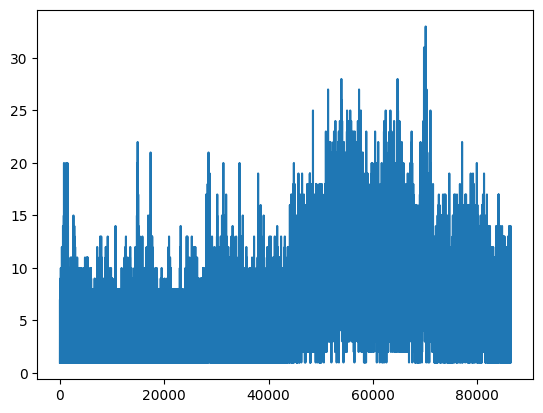

In [20]:
df_plotter = df.groupby("arrival_timestamp_int").agg({"request_id": "count"}).reset_index()
plt.plot(df_plotter["arrival_timestamp_int"], df_plotter["request_id"])
plt.show()

In [25]:
def generate_save_arima_predictions(df, filepath):
    df = df.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
    df["arrival_timestamp_int"] = df["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
    df = df.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
    model = ARIMA(df.prompt_size, order=(3,1,2))
    model_fit = model.fit()
    preds = model_fit.predict()
    df_preds = pd.DataFrame({"Predicted": preds, "Time": [i * 60 for i in range(len(preds))]})
    df_preds.to_csv(filepath)
    
    print(model_fit.summary())

    diffs = (preds - df["prompt_size"])
    print("Mean percentage error:", 100 * (np.mean(np.abs(diffs)) / np.mean(df["prompt_size"])))
    plt.plot(df["prompt_size"], label="Actual")
    plt.plot(preds, label="Predicted")
    plt.legend()
    plt.title(f"ARIME prediction for {filepath}")
    plt.show()

/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1440
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -19117.676
Date:                Mon, 18 Nov 2024   AIC                          38247.352
Time:                        09:40:46   BIC                          38278.982
Sample:                             0   HQIC                         38259.160
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3934      0.313      1.258      0.208      -0.219       1.006
ar.L2          0.0098      0.064      0.155      0.877      -0.115       0.134
ar.L3          0.0757      0.030      2.510      0.0

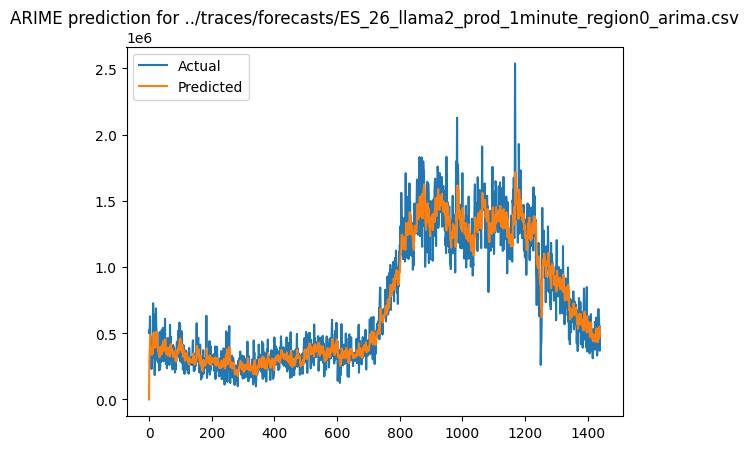

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1440
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -19126.728
Date:                Mon, 18 Nov 2024   AIC                          38265.457
Time:                        09:40:49   BIC                          38297.087
Sample:                             0   HQIC                         38277.265
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3774      0.214     -1.766      0.077      -0.796       0.042
ar.L2          0.2342      0.061      3.843      0.000       0.115       0.354
ar.L3          0.1106      0.027      4.097      0.0

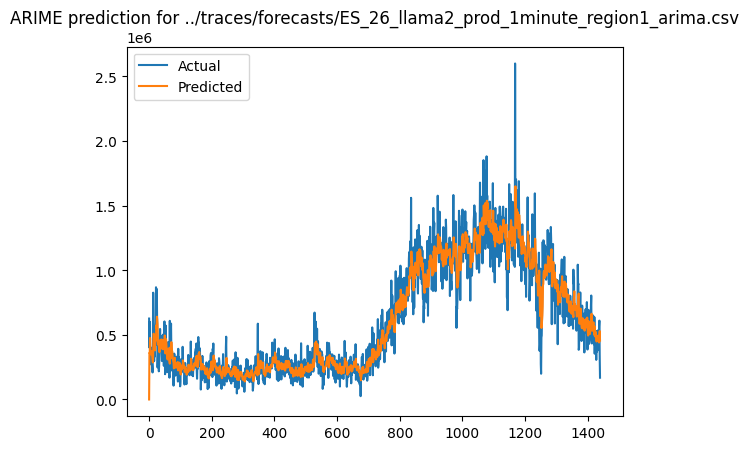

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1440
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -18821.122
Date:                Mon, 18 Nov 2024   AIC                          37654.244
Time:                        09:40:51   BIC                          37685.874
Sample:                             0   HQIC                         37666.051
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7828      0.164      4.772      0.000       0.461       1.104
ar.L2         -0.0385      0.044     -0.884      0.377      -0.124       0.047
ar.L3          0.0424      0.032      1.327      0.1

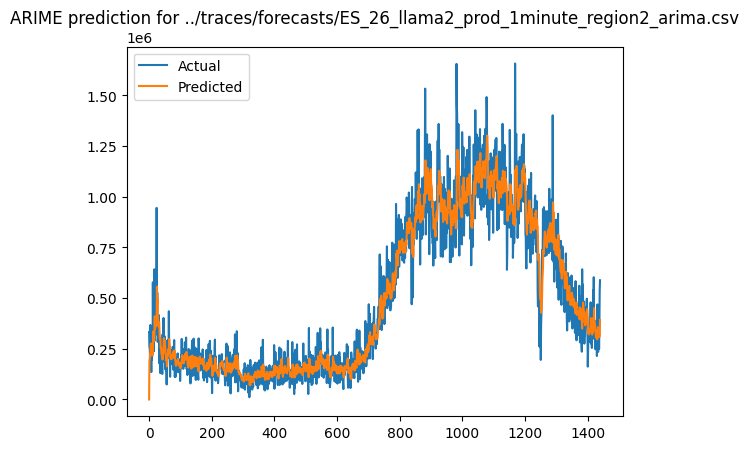

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1440
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -17515.982
Date:                Mon, 18 Nov 2024   AIC                          35043.963
Time:                        09:40:53   BIC                          35075.593
Sample:                             0   HQIC                         35055.771
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3683      6.717     -0.055      0.956     -13.533      12.797
ar.L2          0.4238      2.839      0.149      0.881      -5.141       5.988
ar.L3          0.0725      0.596      0.122      0.9

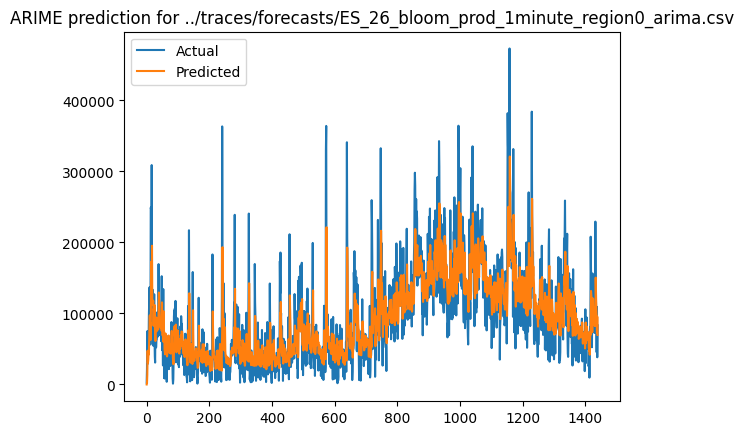

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1438
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -17085.812
Date:                Mon, 18 Nov 2024   AIC                          34183.624
Time:                        09:40:56   BIC                          34215.246
Sample:                             0   HQIC                         34195.430
                               - 1438                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0641      0.455      0.141      0.888      -0.827       0.955
ar.L2          0.1885      0.115      1.639      0.101      -0.037       0.414
ar.L3          0.0885      0.074      1.199      0.2

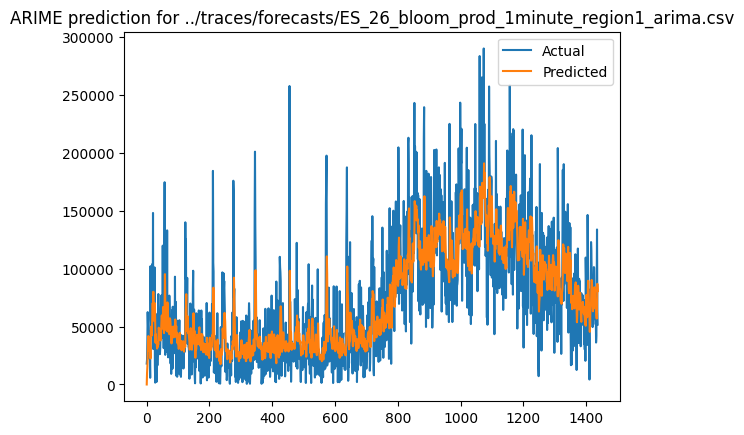

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1428
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -16548.706
Date:                Mon, 18 Nov 2024   AIC                          33109.412
Time:                        09:40:58   BIC                          33140.992
Sample:                             0   HQIC                         33121.206
                               - 1428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7026      2.142     -0.328      0.743      -4.900       3.495
ar.L2          0.1886      0.326      0.579      0.562      -0.450       0.827
ar.L3          0.0488      0.141      0.347      0.7

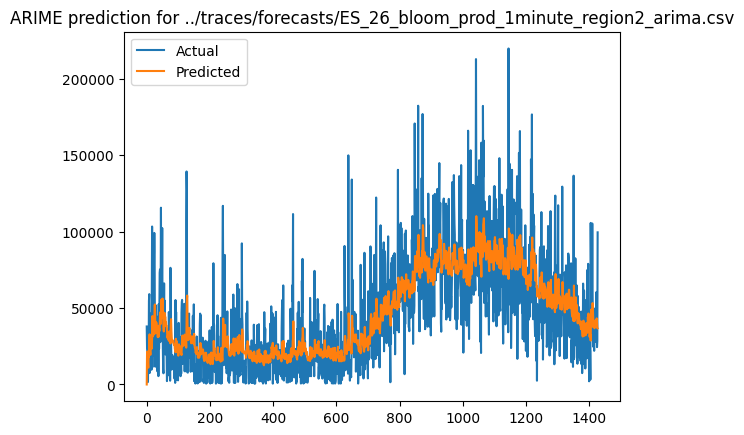

In [26]:
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "llama2-70b") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 0)
)], "../traces/forecasts/ES_26_llama2_prod_1minute_region0_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "llama2-70b") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 1)
)], "../traces/forecasts/ES_26_llama2_prod_1minute_region1_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "llama2-70b") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 2)
)], "../traces/forecasts/ES_26_llama2_prod_1minute_region2_arima.csv")

generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "bloom-176b") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 0)
)], "../traces/forecasts/ES_26_bloom_prod_1minute_region0_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "bloom-176b") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 1)
)], "../traces/forecasts/ES_26_bloom_prod_1minute_region1_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "bloom-176b") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 2)
)], "../traces/forecasts/ES_26_bloom_prod_1minute_region2_arima.csv")

In [6]:
for model in ["bloom-176", "llama2-70b"]:
    for region in [0, 1, 2]:
        df.loc[(
            (df["model_type"] == model) & \
            (df["workload_type"] == "dev") & \
            (df["regions"].apply(lambda x: x//100) == region)
)].to_csv(f"../traces/forecasts/ES_26_{model}_dev_region{region}_exact.csv")

In [6]:
df["model_type"].value_counts()

model_type
llama2-70b    456506
bloom-176b     62657
Name: count, dtype: int64

In [7]:
df_llama2_prod = df.loc[((df["model_type"] == "llama2-70b") & (df["workload_type"] == "prod"))]
df_llama2_dev = df.loc[((df["model_type"] == "llama2-70b") & (df["workload_type"] == "dev"))]
df_bloom_prod = df.loc[((df["model_type"] == "bloom-176b") & (df["workload_type"] == "prod"))]
df_bloom_dev = df.loc[((df["model_type"] == "bloom-176b") & (df["workload_type"] == "dev"))]

In [8]:
df_llama2_prod_discrete = df_llama2_prod.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
df_llama2_dev_discrete = df_llama2_dev.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
df_bloom_prod_discrete = df_bloom_prod.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
df_bloom_dev_discrete = df_bloom_dev.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()

In [9]:
print(df_llama2_prod.shape, df_llama2_dev.shape, df_bloom_prod.shape, df_bloom_dev.shape)

(229592, 9) (226914, 9) (61614, 9) (1043, 9)


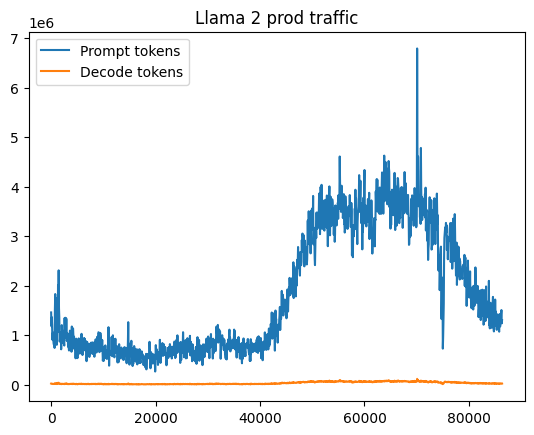

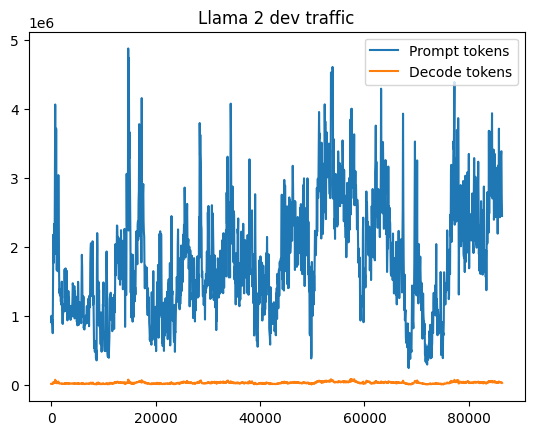

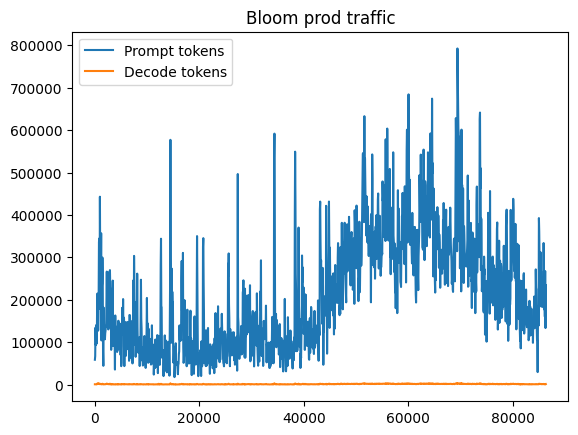

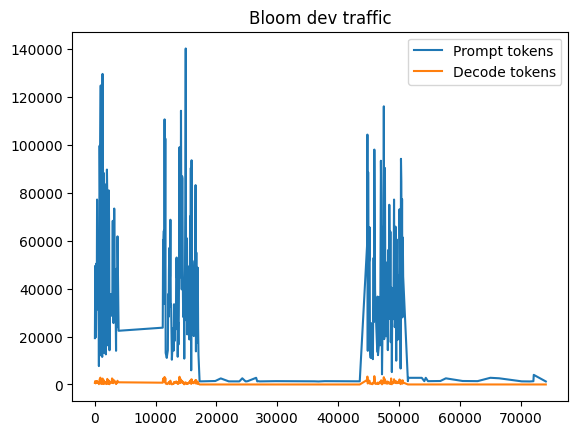

In [10]:
df_temp = df_llama2_prod_discrete.copy()
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
plt.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prompt tokens")
plt.plot(df_temp["arrival_timestamp_int"], df_temp["token_size"], label="Decode tokens")
plt.title("Llama 2 prod traffic")
plt.legend()
plt.show()
df_temp = df_llama2_dev_discrete.copy()
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
plt.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prompt tokens")
plt.plot(df_temp["arrival_timestamp_int"], df_temp["token_size"], label="Decode tokens")
plt.title("Llama 2 dev traffic")
plt.legend()
plt.show()

df_temp = df_bloom_prod_discrete.copy()
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
plt.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prompt tokens")
plt.plot(df_temp["arrival_timestamp_int"], df_temp["token_size"], label="Decode tokens")
plt.title("Bloom prod traffic")
plt.legend()
plt.show()
df_temp = df_bloom_dev_discrete.copy()
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
plt.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prompt tokens")
plt.plot(df_temp["arrival_timestamp_int"], df_temp["token_size"], label="Decode tokens")
plt.title("Bloom dev traffic")
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1440
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -20004.523
Date:                Mon, 18 Nov 2024   AIC                          40021.046
Time:                        08:24:48   BIC                          40052.676
Sample:                             0   HQIC                         40032.854
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3574      0.291      1.229      0.219      -0.212       0.927
ar.L2          0.0555      0.080      0.693      0.489      -0.102       0.213
ar.L3          0.0873      0.032      2.704      0.0

[]

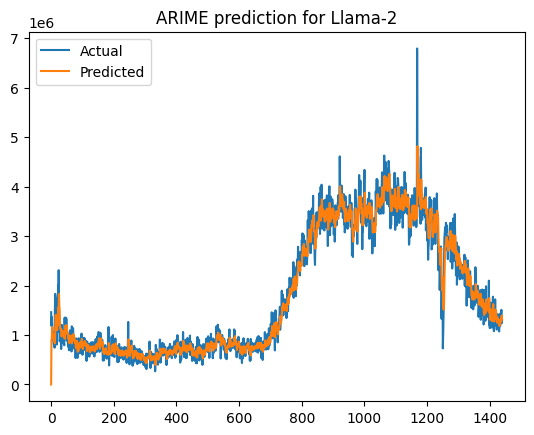

In [13]:
df_temp = df_llama2_prod_discrete.copy()
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
model = ARIMA(df_temp.prompt_size, order=(3,1,2))
model_fit = model.fit()
print(model_fit.summary())

preds = model_fit.predict()

diffs = (preds - df_temp["prompt_size"])
print("Mean percentage error:", 100 * (np.mean(np.abs(diffs)) / np.mean(df_temp["prompt_size"])))
plt.plot(df_temp["prompt_size"], label="Actual")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("ARIME prediction for Llama-2")
plt.plot()

In [17]:
df_preds_llama2 = pd.DataFrame({"Predicted": preds, "Time": [i * 60 for i in range(len(preds))]})

In [18]:
df_preds_llama2.head()

,Predicted,Time
0,0.000000e+00,0
1,8.974725e+05,60
2,9.239877e+05,120
3,1.164083e+06,180
4,1.120572e+06,240


In [24]:
df_preds_llama2.to_csv("../traces/forecasts/ES_26_llama2_prod_arima_1_minute_predicted.csv")

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 1440
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -18141.304
Date:                Mon, 18 Nov 2024   AIC                          36296.608
Time:                        08:27:30   BIC                          36333.510
Sample:                             0   HQIC                         36310.384
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0321      0.315     -0.102      0.919      -0.650       0.586
ar.L2          0.7539      0.223      3.382      0.001       0.317       1.191
ar.L3         -0.1051      0.078     -1.354      0.1

[]

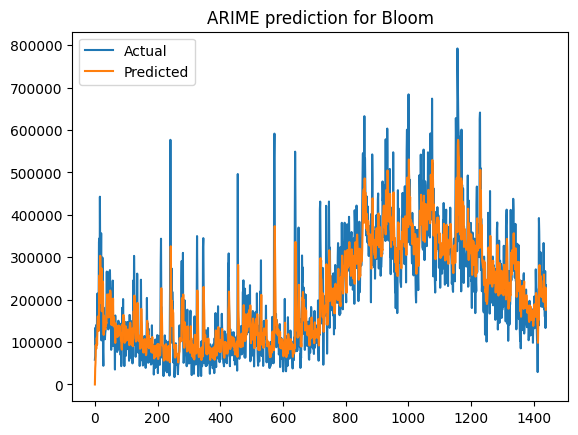

In [20]:
df_temp = df_bloom_prod_discrete.copy()
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
model = ARIMA(df_temp.prompt_size, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

preds = model_fit.predict()

diffs = (preds - df_temp["prompt_size"])
print("Mean percentage error:", 100 * (np.mean(np.abs(diffs)) / np.mean(df_temp["prompt_size"])))
plt.plot(df_temp["prompt_size"], label="Actual")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("ARIME prediction for Bloom")
plt.plot()

In [21]:
df_preds_bloom = pd.DataFrame({"Predicted": preds, "Time": [i*60 for i in range(len(preds))]})

In [22]:
df_preds_bloom.head()

,Predicted,Time
0,0.000000,0
1,38029.607292,60
2,51192.101119,120
3,92393.548553,180
4,83547.239514,240


In [23]:
df_preds_bloom.to_csv("../traces/forecasts/ES_26_bloom_prod_arima_1_minute_predicted.csv")